# Exploratory analysis of post-Mpeak growth

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

In [3]:
from collate_full_catalog import collate_catalog
z_string = 'z0'


history_colnames = ('halo_id', 'halo_upid', 'halo_mpeak', 'halo_vmax_at_mpeak', 'halo_tidal_force', 
                'stellar_mass', 'sfr', 'sfr_mp', 'sm_mp')
halocat_propnames = ('halo_id', 'first_acc_scale', 'acc_rate_1tdyn', 
                     'mpeak_scale', 'delta_vmax_tdyn_behroozi16')

cat = collate_catalog(z_string, history_colnames=history_colnames, 
                      halocat_propnames=halocat_propnames, verbose=True)

... Assembling history data
... Assembling halo catalog data
... Cross-matching on halo_id

Number of objects in history catalog = 701037
Number of objects in halo catalog = 12085858
Number of matching objects = 646460
Fraction of objects appearing in both catalogs = 0.922
New colnames to add from halo catalog = ['first_acc_scale', 'mpeak_scale', 'delta_vmax_tdyn_behroozi16', 'acc_rate_1tdyn']


In [4]:
orphan_mask = cat['orphan'] == True

mpeak_cosmic_age = np.ones(len(orphan_mask))
mpeak_cosmic_age = np.interp(cat['mpeak_scale'], scale_factor_array, cosmic_age_array)
cat['mpeak_cosmic_age'] = mpeak_cosmic_age

mpeak_redshift = np.zeros(len(orphan_mask))
mpeak_redshift[~orphan_mask] = 1./cat['mpeak_scale'][~orphan_mask] - 1.

In [5]:
num_gals = cat['sm_mp'].shape[0]
idx_mpeak_scale = np.searchsorted(scale_factor_array, cat['mpeak_scale'])
stellar_mass_at_mpeak_scale = cat['sm_mp'][np.arange(num_gals), idx_mpeak_scale]
idx_mpeak_scale.min(), idx_mpeak_scale.max()

(0, 177)

In [6]:
cat['stellar_mass_at_mpeak_scale'] = stellar_mass_at_mpeak_scale

In [7]:
from halotools.mock_observables import mean_y_vs_x

In [103]:
_bins = 10**np.linspace(10.5, 14.25, 20)

mpeak_abscissa, sm_all, sm_all_err = mean_y_vs_x(cat['halo_mpeak'], cat['stellar_mass'], bins=_bins)
logmpeak_abscissa, log_sm_all = np.log10(mpeak_abscissa), np.log10(sm_all)

nonzero_mask_all = cat['stellar_mass_at_mpeak_scale'] > 0
__, sm_at_mpeak_all, sm_all_at_mpeak_err = mean_y_vs_x(cat['halo_mpeak'], 
                                                        cat['stellar_mass_at_mpeak_scale'],
                                                        bins = _bins)
log_sm_at_mpeak_all = np.log10(sm_at_mpeak_all)

In [104]:
cenmask = cat['halo_upid'] == -1

mpeak_abscissa_cens, sm_cens, sm_err_cens = mean_y_vs_x(cat['halo_mpeak'][cenmask], 
                                                        cat['stellar_mass'][cenmask],
                                                        bins = _bins)
log_mpeak_abscissa_cens, log_sm_cens = np.log10(mpeak_abscissa_cens), np.log10(sm_cens)


__, sm_at_mpeak_cens, sm_at_mpeak_err_cens = mean_y_vs_x(cat['halo_mpeak'][cenmask], 
                                                               cat['stellar_mass_at_mpeak_scale'][cenmask],
                                                               bins = _bins)
log_sm_at_mpeak_cens = np.log10(sm_at_mpeak_cens)

mpeak_abscissa_sats, sm_sats, sm_err_sats = mean_y_vs_x(cat['halo_mpeak'][~cenmask], 
                                                               cat['stellar_mass'][~cenmask],
                                                               bins = _bins)
log_mpeak_abscissa_sats, log_sm_sats = np.log10(mpeak_abscissa_sats), np.log10(sm_sats)
__, sm_at_mpeak_sats, sm_at_mpeak_err_sats = mean_y_vs_x(cat['halo_mpeak'][~cenmask], 
                                                               cat['stellar_mass_at_mpeak_scale'][~cenmask],
                                                               bins = _bins)
log_sm_at_mpeak_sats = np.log10(sm_at_mpeak_sats)

sm_cens_ratio = sm_cens/sm_all
sm_cens_at_mpeak_ratio = sm_at_mpeak_cens/sm_at_mpeak_all
sm_cens_to_mpeak_ratio = sm_at_mpeak_cens/sm_cens

sm_sats_ratio = sm_sats/sm_all
sm_sats_at_mpeak_ratio = sm_at_mpeak_sats/sm_at_mpeak_all
sm_sats_to_mpeak_ratio = sm_at_mpeak_sats/sm_sats

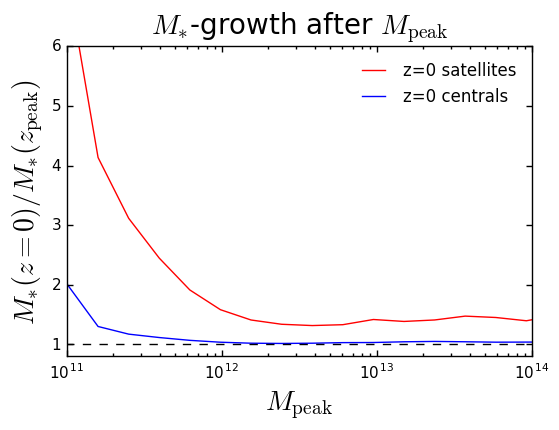

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\rm peak}$', fontsize=20)
ylabel = ax.set_ylabel(r'$M_{\ast}(z=0) / M_{\ast}(z_{\rm peak})$', fontsize=20)
title = ax.set_title(r'$M_{\ast}$-growth after $M_{\rm peak}$', fontsize=20, y=1.02) # y param fixes an overhanging title

ax.plot(10**log_mpeak_abscissa_sats, sm_sats/sm_at_mpeak_sats, color='red', label='z=0 satellites')
ax.plot(10**log_mpeak_abscissa_cens, sm_cens/sm_at_mpeak_cens, color='blue', label='z=0 centrals')

_x = np.linspace(10.5, 14, 100)
ax.plot(10**_x, np.ones_like(_x), '--', color='k')

plt.xlim(xmin = 1e11, xmax=1e14)
plt.ylim(ymin = 0.8, ymax = 6)

plt.xscale('log')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

ax.legend(frameon=False, loc='upper right')

In [110]:
cenmask = cat['halo_upid'] == -1

mpeak_abscissa, mpeak_time_all, __ = mean_y_vs_x(cat['halo_mpeak'], cat['mpeak_cosmic_age'], bins=_bins)

__, mpeak_time_cens, __ = mean_y_vs_x(cat['halo_mpeak'][cenmask], 
                                                        cat['mpeak_cosmic_age'][cenmask],
                                                        bins = _bins)
__, mpeak_time_sats, __ = mean_y_vs_x(cat['halo_mpeak'][~cenmask], 
                                                        cat['mpeak_cosmic_age'][~cenmask],
                                                        bins = _bins)

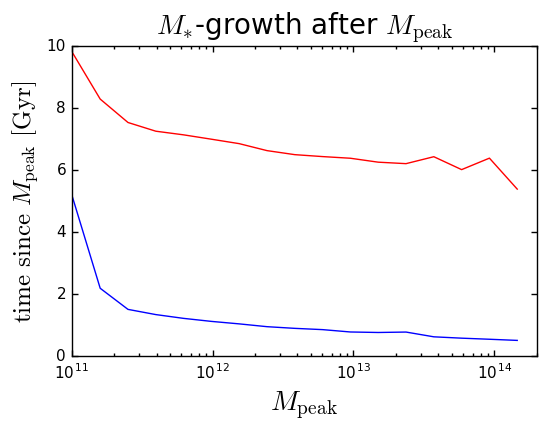

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\rm peak}$', fontsize=20)
ylabel = ax.set_ylabel(r'${\rm time}$ ${\rm since}$ $M_{\rm peak}$ $[{\rm Gyr}]$', fontsize=18)
title = ax.set_title(r'$M_{\ast}$-growth after $M_{\rm peak}$', fontsize=20, y=1.02) # y param fixes an overhanging title

ax.plot(10**log_mpeak_abscissa_cens, 13.8-mpeak_time_cens, color='blue', label='z=0 centrals')
ax.plot(10**log_mpeak_abscissa_sats, 13.8-mpeak_time_sats, color='red', label='z=0 satellites')

plt.xlim(xmin = 1e11, xmax=2e14)
plt.ylim(ymin = 0, ymax = 10)

plt.xscale('log')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

In [ ]:
cat['stellar_mass_at_mpeak_scale'][~cenmask].min()

In [ ]:
log_sm_sats/log_sm_at_mpeak_sats

In [ ]:
mask = (cat['halo_mpeak'] > 1e12) & (cat['halo_mpeak'] < 2e12)
sample = cat[mask]
sample_cenmask = sample['halo_upid'] == -1
print('satellite fraction = {0:.2f}'.format(len(sample[~sample_cenmask])/float(len(sample))))

In [ ]:
np.mean(np.log10(sample['stellar_mass'][sample_cenmask])), np.mean(np.log10(sample['stellar_mass'][~sample_cenmask]))

In [ ]:
print(log_mpeak_abscissa[13], log_mpeak_abscissa[16])

In [ ]:
log_sm_sats[13:16]

In [ ]:
log_sm_cens[13:16]

In [ ]:
np.log10(2e12)

In [ ]:
cat['halo_mpeak'].max()

In [ ]:
log_mpeak_abscissa

In [ ]:
np.log10(cat['stellar_mass_at_mpeak_scale']).min()